In [33]:
import sys
import os
#import torch
import zarr
import lilio
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from pathlib import Path
from scipy.stats import linregress, spearmanr
from typing import Union
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.pipeline import Pipeline
from matplotlib.gridspec import GridSpec

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from Medley.dataloading import get_monthly_data, prep_ecad, datapath, prep_and_resample
from Medley.utils import data_for_pcolormesh, udomains, regions, tscolnames
from Medley.analysis import trendfit_robust
from Medley.preprocessing import Anomalizer, simultaneous_resample, makemask, average_within_mask, single_target_lagged_resample, multi_target_lagged_resample,remove_bottleneck, make_pipeline
from Medley.crossval import SpatiotemporalSplit
from Medley.visualization import plot_stations, plot_plus_stations

In [2]:
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS 
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI

ModuleNotFoundError: No module named 'tigramite'

In [38]:
df = get_monthly_data()
#variables = [('enso',34,'ersstv5'),('amoc',0,'hadisst'),('nao',0,'station'),('ao',0,'ncep'),('vortex_u20',7080,'era5'),('med_u250',30,'era5')]
#variables = [('enso',34,'ersstv5'),('amoc',0,'hadisst'),('nao',0,'station'),('ao',0,'ncep'),('vortex_u20',7080,'era5'),('med_u250_latmax',0,'era5')]
variables = [('enso', 12, 'ersstv5'), ('ao', 0, 'ncep'), ('med_u250', 60, 'era5'), ('med_u500_latmax', 0, 'era5'), ('med_u500', 20, 'era5'), ('med_u500', 60, 'era5'), ('atl_u500', 40, 'era5')]

In [35]:
prep_kwargs= dict(
    target_region = regions['medwest'],
    target_var = 'SPI3',
    minsamples = 10, # numer of stations
    resampling = 'multi', # whether multiple targets / samples are desired per anchor year
    shift = True,
    resampling_kwargs = dict(
        precursor_agg = 1, # Number of months
        n = 2, # number of lags
        separation = 0, #step per lag
        target_agg = 1, # ignored if resampling == 'single', as aggregation will be based on first/last
        firstmonth = 12, # How to define the winter period (with lastmonth)
        lastmonth = 3,
        ),
    )

Xm, ym, cal = prep_and_resample(**prep_kwargs)

Xm =  Xm.loc[:,variables]

/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/p

/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/p

/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/p

/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/p

/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/lilio/resampling.py:168: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/SUPERVENV/lib/p

In [39]:
df[variables]

name          enso   ao med_u250 med_u500_latmax med_u500      atl_u500
subindex        12   0        60              0        20   60       40
product    ersstv5 ncep     era5            era5     era5 era5     era5
1821-01-01     NaN  NaN      NaN             NaN      NaN  NaN      NaN
1821-02-01     NaN  NaN      NaN             NaN      NaN  NaN      NaN
1821-03-01     NaN  NaN      NaN             NaN      NaN  NaN      NaN
1821-04-01     NaN  NaN      NaN             NaN      NaN  NaN      NaN
1821-05-01     NaN  NaN      NaN             NaN      NaN  NaN      NaN
...            ...  ...      ...             ...      ...  ...      ...
2023-08-01     NaN  NaN      NaN             NaN      NaN  NaN      NaN
2023-09-01     NaN  NaN      NaN             NaN      NaN  NaN      NaN
2023-10-01     NaN  NaN      NaN             NaN      NaN  NaN      NaN
2023-11-01     NaN  NaN      NaN             NaN      NaN  NaN      NaN
2023-12-01     NaN  NaN      NaN             NaN      NaN  NaN      NaN

[2436 rows x 7 columns]

In [29]:
shift = True
anomalize = False

In [30]:
target = prep_ecad(target_region=regions['medwest'], target_var = 'SPI3', shift = shift).to_frame()
target.columns = pd.MultiIndex.from_tuples([('SPI3',0,'ECAD')], names = tscolnames)
if anomalize:
    a = Anomalizer()
    df = a.fit_transform(df)

In [31]:
joined = df.loc[:,variables].join(target, how = 'inner').dropna()


In [32]:
# potential writing out
joined.to_csv(f'/scistor/ivm/jsn295/Medi/expert-set_shift-{shift}_season-removed-{anomalize}.csv')

In [ ]:
frame = pp.DataFrame(joined.values, datatime = joined.index,var_names = joined.columns.get_level_values(0))

#### Seasonal masking (jfm in western med behave similarly)
True if to-be left out

In [24]:
jfmmask = np.tile(~joined.index.month.isin([12,1,2,3])[:,np.newaxis], (1,joined.shape[-1]))
jfmframe = pp.DataFrame(joined.values, datatime = joined.index,var_names = joined.columns.get_level_values(0),mask = jfmmask)

#### Regime dependent masking
remove amoc from the dataframe because now a conditioning variable

In [25]:
noamoc = joined.drop('amoc', axis = 1)
amoc_quantiles = (0.33,0.66)
amoc_thresholds = joined['amoc'].squeeze().quantile(amoc_quantiles)
amoc_minus_mask = np.logical_or(np.tile(joined['amoc'] > amoc_thresholds.loc[amoc_quantiles[0]], (1,noamoc.shape[-1])), jfmmask[:,:-1])
amoc_plus_mask = np.logical_or(np.tile(joined['amoc'] < amoc_thresholds.loc[amoc_quantiles[1]], (1,noamoc.shape[-1])), jfmmask[:,:-1])

/tmp/ipykernel_3800971/1563457225.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  noamoc = joined.drop('amoc', axis = 1)


In [26]:
amoc_minus_frame = pp.DataFrame(noamoc.values, datatime = noamoc.index,var_names = noamoc.columns.get_level_values(0),mask = amoc_minus_mask)
amoc_plus_frame = pp.DataFrame(noamoc.values, datatime = noamoc.index,var_names = noamoc.columns.get_level_values(0),mask = amoc_plus_mask)

#### Investigation

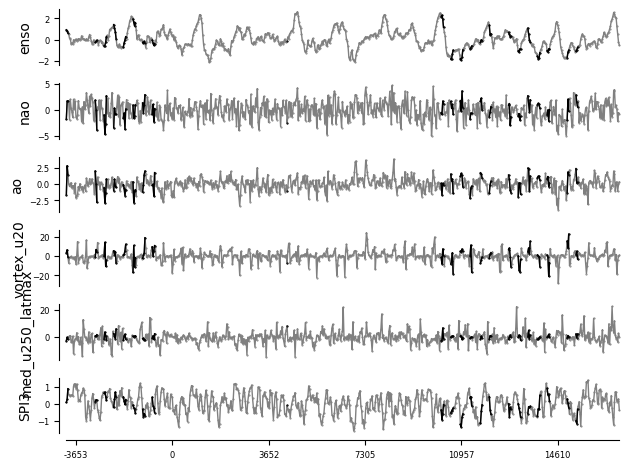

In [27]:
tp.plot_timeseries(amoc_plus_frame, grey_masked_samples='data'); plt.show()

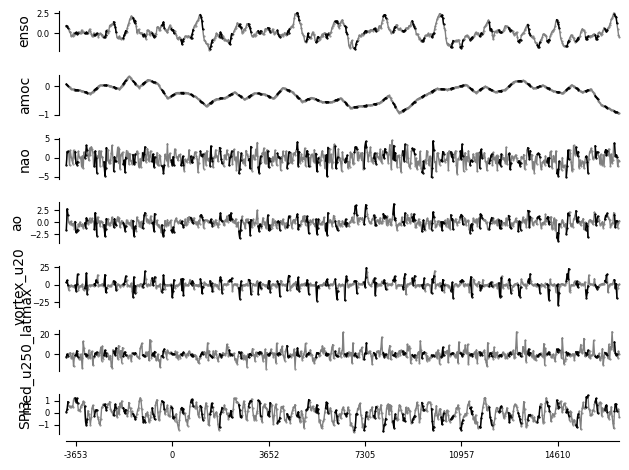

In [28]:
tp.plot_timeseries(jfmframe, grey_masked_samples='data'); plt.show()

#### Wintertime graph

In [32]:
parcorr = ParCorr(significance='analytic',mask_type = 'y')
pcmci = PCMCI(
    dataframe=jfmframe, 
    cond_ind_test=parcorr,
    verbosity=1)
tau_max = 1
tau_min = 1
results = pcmci.run_pcmci(tau_max=tau_max, tau_min = tau_min, pc_alpha=None, alpha_level=0.05)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable enso has 2 link(s):
    [pc_alpha = 0.2]
        (enso -1): max_pval = 0.00000, |min_val| =  0.960
        (amoc -1): max_pval = 0.15836, |min_val| =  0.094

    Variable amoc has 3 link(s):
    [pc_alpha = 0.3]
        (amoc -1): max_pval = 0.00000, |min_val| =  0.997
        (enso -1): max_pval = 0.00237, |min_val| =  0.200
        (SPI3 -1): max_pval = 0.25689, |min_val| =  0.075

    Variable nao has 3 link(s):
    [pc_alpha = 0.1]
        (SPI3 -1): max_pval = 0.00000, |min_val| =  0.353
        (amoc -1): max_pval = 0.00469, |min_val| =  0.187
        (ao -1): max_pval = 0.08436, |min_val| =  0.115

    Variable ao has 6 link(s):
    [pc_alpha = 0.2]
        (SPI3 -1): max_pval = 0.00000, |min_val| =  0.353
     

In [33]:
graph = pcmci.get_graph_from_pmatrix(p_matrix=results['p_matrix'], alpha_level=0.05, 
            tau_min=tau_min, tau_max=tau_max, link_assumptions=None)
results['graph'] = graph

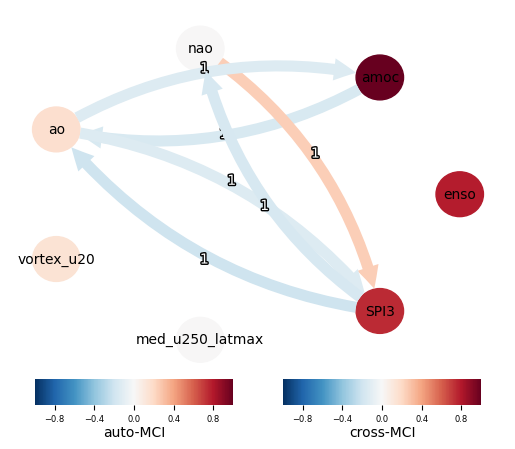

In [34]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=frame.var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()

#### AMOC conditioned regimes

In [128]:
parcorr = ParCorr(significance='analytic',mask_type = 'y')
pcmci = PCMCI(
    dataframe=amoc_minus_frame, 
    cond_ind_test=parcorr,
    verbosity=1)
tau_max = 1
tau_min = 0
results = pcmci.run_pcmci(tau_max=tau_max, tau_min = tau_min, pc_alpha=None, alpha_level=0.05)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable enso has 1 link(s):
    [pc_alpha = 0.05]
        (enso -1): max_pval = 0.00000, |min_val| =  0.959

    Variable nao has 2 link(s):
    [pc_alpha = 0.3]
        (SPI3 -1): max_pval = 0.23650, |min_val| =  0.164
        (vortex_u20 -1): max_pval = 0.26039, |min_val| =  0.156

    Variable ao has 3 link(s):
    [pc_alpha = 0.3]
        (ao -1): max_pval = 0.01045, |min_val| =  0.346
        (enso -1): max_pval = 0.28319, |min_val| =  0.150
        (nao -1): max_pval = 0.28819, |min_val| =  0.146

    Variable vortex_u20 has 1 link(s):
    [pc_alpha = 0.05]
        (ao -1): max_pval = 0.03392, |min_val| =  0.287

    Variable med_u250_latmax has 1 link(s):
    [pc_alpha = 0.2]
        (med_u250_latmax -1): max_pval = 0.1

In [129]:
graph = pcmci.get_graph_from_pmatrix(p_matrix=results['p_matrix'], alpha_level=0.05, 
            tau_min=tau_min, tau_max=tau_max, link_assumptions=None)
results['graph'] = graph

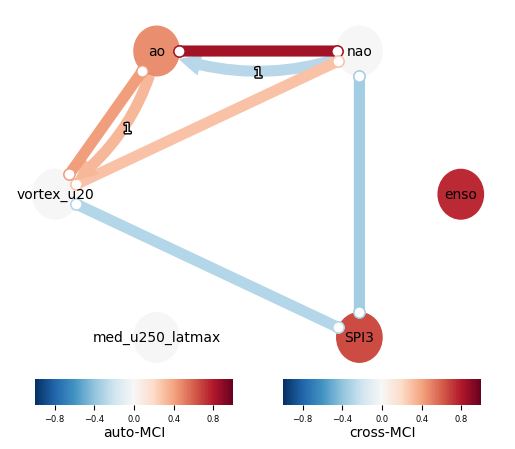

In [130]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=amoc_minus_frame.var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()

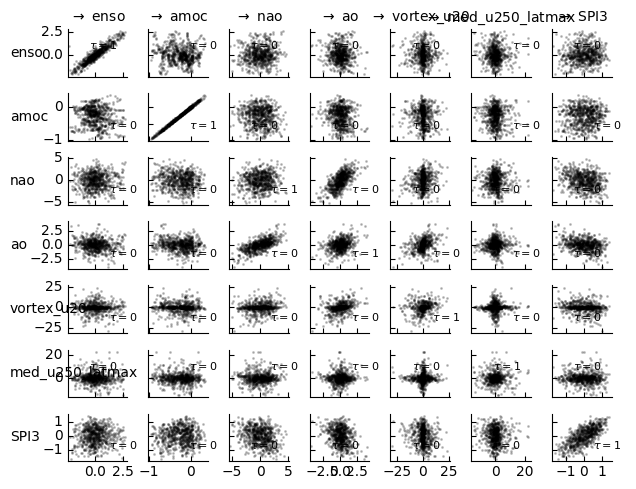

In [17]:
tp.plot_scatterplots(dataframe=frame, add_scatterplot_args={'matrix_lags':None}); plt.show()

In [114]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=frame, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=12, val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 12


In [99]:
np.argmax(np.abs(correlations), axis = 2)

array([[ 1,  7, 22,  2,  3, 31, 28],
       [36,  1, 11, 11, 36,  0, 21],
       [ 7, 13, 28,  0,  0,  0,  0],
       [ 0, 15,  0,  1,  0, 25,  1],
       [ 7, 15,  0,  0,  1,  1,  0],
       [36,  4,  0, 11, 10,  1,  0],
       [10, 32,  0,  0,  0, 29,  1]])

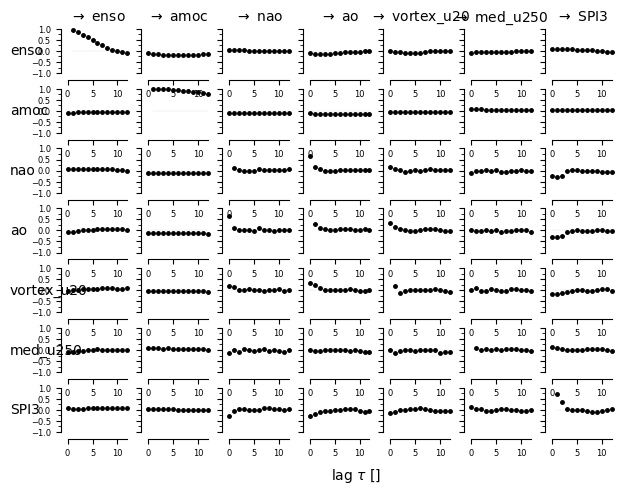

In [115]:
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':frame.var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

In [116]:
parcorr = ParCorr(significance='analytic',mask_type = 'y')
pcmci = PCMCI(
    dataframe=jfmframe, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=12, val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 12


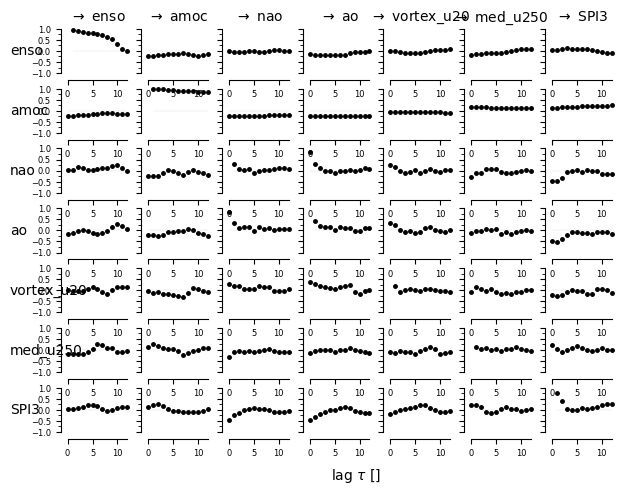

In [117]:
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':frame.var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

In [156]:
tau_max = 4
tau_min = 1
results = pcmci.run_pcmci(tau_max=tau_max, tau_min = tau_min, pc_alpha=None, alpha_level=0.01)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 4
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable enso has 2 link(s):
    [pc_alpha = 0.05]
        (enso -1): max_pval = 0.00000, |min_val| =  0.750
        (enso -2): max_pval = 0.00248, |min_val| =  0.231

    Variable amoc has 4 link(s):
    [pc_alpha = 0.2]
        (amoc -4): max_pval = 0.00000, |min_val| =  0.691
        (amoc -1): max_pval = 0.00000, |min_val| =  0.554
        (amoc -3): max_pval = 0.00148, |min_val| =  0.243
        (vortex_u20 -3): max_pval = 0.15851, |min_val| =  0.110

    Variable nao has 3 link(s):
    [pc_alpha = 0.2]
        (ao -1): max_pval = 0.02364, |min_val| =  0.174
        (amoc -4): max_pval = 0.12796, |min_val| =  0.118
        (vortex_u20 -1): max_pval = 0.17742, |min_val| =  0.105

    Variable ao has 6 link(s):
    [pc_alpha

In [157]:
graph = pcmci.get_graph_from_pmatrix(p_matrix=results['p_matrix'], alpha_level=0.01, 
            tau_min=tau_min, tau_max=tau_max, link_assumptions=None)
results['graph'] = graph

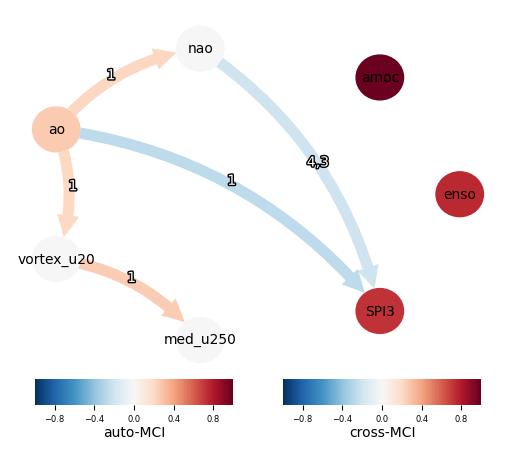

In [158]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=frame.var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()

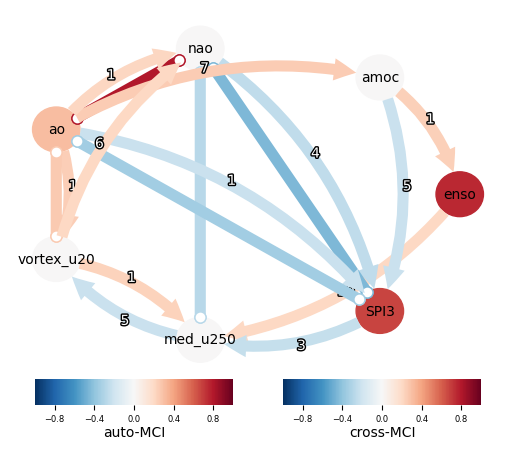

In [131]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=frame.var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()

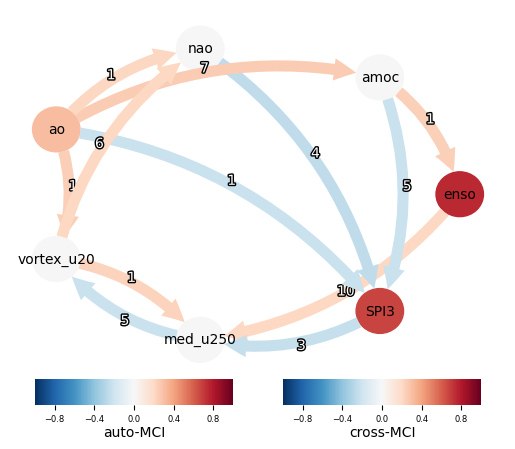

In [128]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=frame.var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()

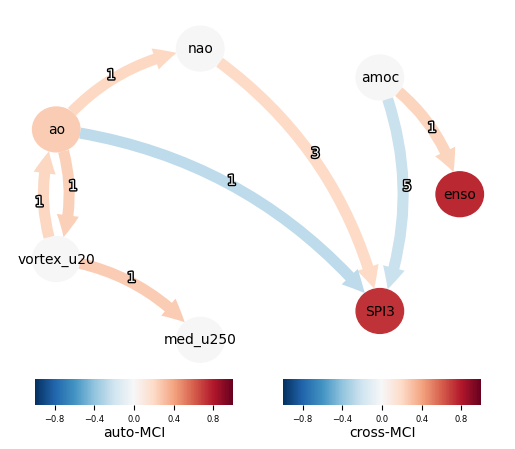

In [124]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=frame.var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()